In [81]:
import os, sys
import time
import random
import requests
import queue
from IPython.display import Image

#### Concurrency and Parallelism

In [14]:
def download_site(url, session):
    with session.get(url) as response:
        print(f"Read {len(response.content)} from {url}")


def download_all_sites(sites):
    with requests.Session() as session:
        for url in sites:
            download_site(url, session)

In [15]:
sites = [
    "https://www.jython.org",
    "http://olympus.realpython.org/dice",
] * 80

In [16]:
start_time = time.time()
download_all_sites(sites)
duration = time.time() - start_time
print(f"Downloaded {len(sites)} in {duration} seconds")

Read 10287 from https://www.jython.org
Read 274 from http://olympus.realpython.org/dice
Read 10287 from https://www.jython.org
Read 274 from http://olympus.realpython.org/dice
Read 10287 from https://www.jython.org
Read 274 from http://olympus.realpython.org/dice
Read 10287 from https://www.jython.org
Read 274 from http://olympus.realpython.org/dice
Read 10287 from https://www.jython.org
Read 274 from http://olympus.realpython.org/dice
Read 10287 from https://www.jython.org
Read 274 from http://olympus.realpython.org/dice
Read 10287 from https://www.jython.org
Read 274 from http://olympus.realpython.org/dice
Read 10287 from https://www.jython.org
Read 274 from http://olympus.realpython.org/dice
Read 10287 from https://www.jython.org
Read 274 from http://olympus.realpython.org/dice
Read 10287 from https://www.jython.org
Read 274 from http://olympus.realpython.org/dice
Read 10287 from https://www.jython.org
Read 274 from http://olympus.realpython.org/dice
Read 10287 from https://www.jyth

#### Threading
ThreadPoolExecutor = Thread + Pool + Executor

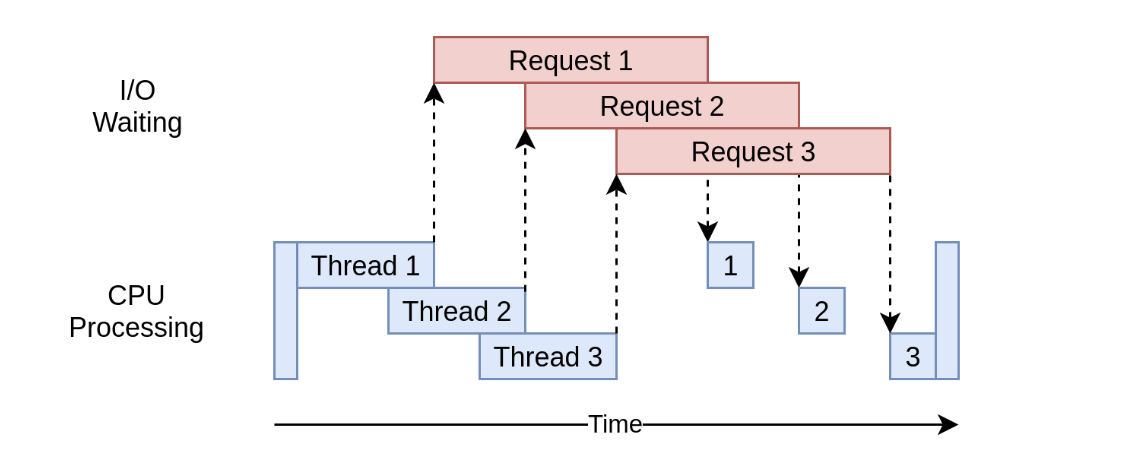

In [15]:
Image("/Users/shisi/Desktop/threading.png", height=100, width=600)

##### joining thread

In [59]:
import concurrent.futures
import threading

In [64]:
thread_local = threading.local()

def get_session():
    if not hasattr(thread_local, "session"):
        thread_local.session = requests.Session()
    return thread_local.session

def download_site(url):
    session = get_session()
    with session.get(url) as response:
        print(f"Read {len(response.content)} from {url}")

In [73]:
start_time = time.time()
t = threading.Thread(target=download_site, args=[sites[0]])
t.start()
t.join() # let the main thread wait until the other threads to finish before ending the program
duration = time.time() - start_time
print(f"Main thread finished in {duration} secs")

Read 10287 from https://www.jython.org
Main thread finished in 0.05040097236633301 secs


##### thread pool

In [70]:
def download_all_sites(sites):
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        executor.map(download_site, sites)

In [1]:
start_time = time.time()
download_all_sites(sites)
duration = time.time() - start_time
print(f"Downloaded {len(sites)} in {duration} seconds with Multi-threading")

##### producer-consumer pipeline

In [86]:
class Pipeline(queue.Queue):
    # Queue object handles locking automatically
    def __init__(self, capacity):
        super().__init__(maxsize=capacity)

    def set_message(self, message):
        print(f"producing message of {message}")
        self.put(message)

    def get_message(self):
        message = self.get()
        print(f"consuming message of {message}")
        return message
    

def producer(pipeline, event):
    while not event.is_set():
        message = random.randint(1, 100)
        pipeline.set_message(message)
    

def consumer(pipeline, event):
    while not pipeline.empty() or not event.is_set():
        print(f"queue size is {pipeline.qsize()}")
        message = pipeline.get_message()
        time.sleep(random.randint(1, 3))

In [87]:
pipeline = Pipeline(10)
event = threading.Event() # .set(), .reset() to flag
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    executor.submit(producer, pipeline, event)
    executor.submit(consumer, pipeline, event)
    time.sleep(0.5)
    event.set()

producing message of 75queue size is 0
producing message of 14
producing message of 50
producing message of 92
producing message of 72
producing message of 38
producing message of 46
producing message of 69
producing message of 13
producing message of 7
producing message of 63

consuming message of 75
producing message of 59
queue size is 10
consuming message of 14
queue size is 10
consuming message of 50
queue size is 9
consuming message of 92
queue size is 8
consuming message of 72
queue size is 7
consuming message of 38
queue size is 6
consuming message of 46
queue size is 5
consuming message of 69
queue size is 4
consuming message of 13
queue size is 3
consuming message of 7
queue size is 2
consuming message of 63
queue size is 1
consuming message of 59


#### asyncio

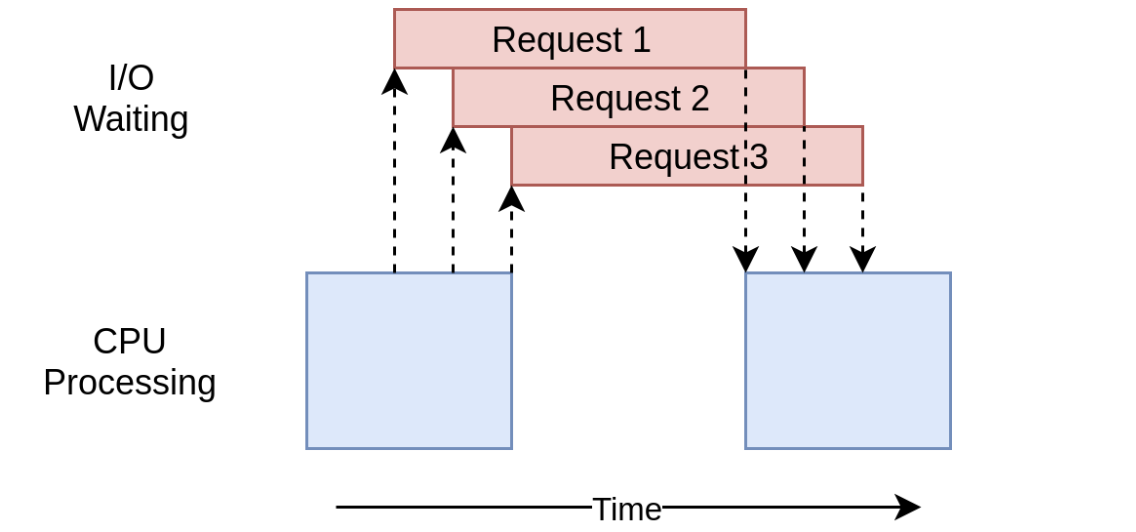

In [28]:
Image("/Users/shisi/Desktop/asyncio.png", height=100, width=600)

In [4]:
import asyncio
# !pip install aiohttp
import aiohttp
import nest_asyncio
nest_asyncio.apply()

In [31]:
async def download_site(session, url):
    async with session.get(url) as response:
        print(f"Read {len(response.content)} from {url}")

async def download_all_sites(sites):
    async with aiohttp.ClientSession() as session:
        tasks = []
        for url in sites:
            task = asyncio.ensure_future(download_site(session, url))
            tasks.append(task)
        await asyncio.gather(*tasks, return_exceptions=True)

In [32]:
start_time = time.time()
asyncio.get_event_loop().run_until_complete(download_all_sites(sites))
duration = time.time() - start_time
print(f"Downloaded {len(sites)} in {duration} seconds with asyncio.")

Downloaded 160 in 0.23812031745910645 seconds with asyncio.


##### asynchornous generator

In [52]:
def odds(start, end):
    for odd in range(start, end + 1):
        yield odd

async def randn():
    await asyncio.sleep(3)
    return random.randint(1, 10)

In [49]:
async def square_odds(start, stop):
    for odd in odds(start, stop):
        await asyncio.sleep(2)
        yield odd ** 2

In [58]:
async def run_async():
    async for num in square_odds(11, 17):
        print("squared odd number:", num)

asyncio.run(run_async())

squared odd number: 121
squared odd number: 144
squared odd number: 169
squared odd number: 196
squared odd number: 225
squared odd number: 256
squared odd number: 289


#### multiprocessing

##### I/O Bound multiprocessing

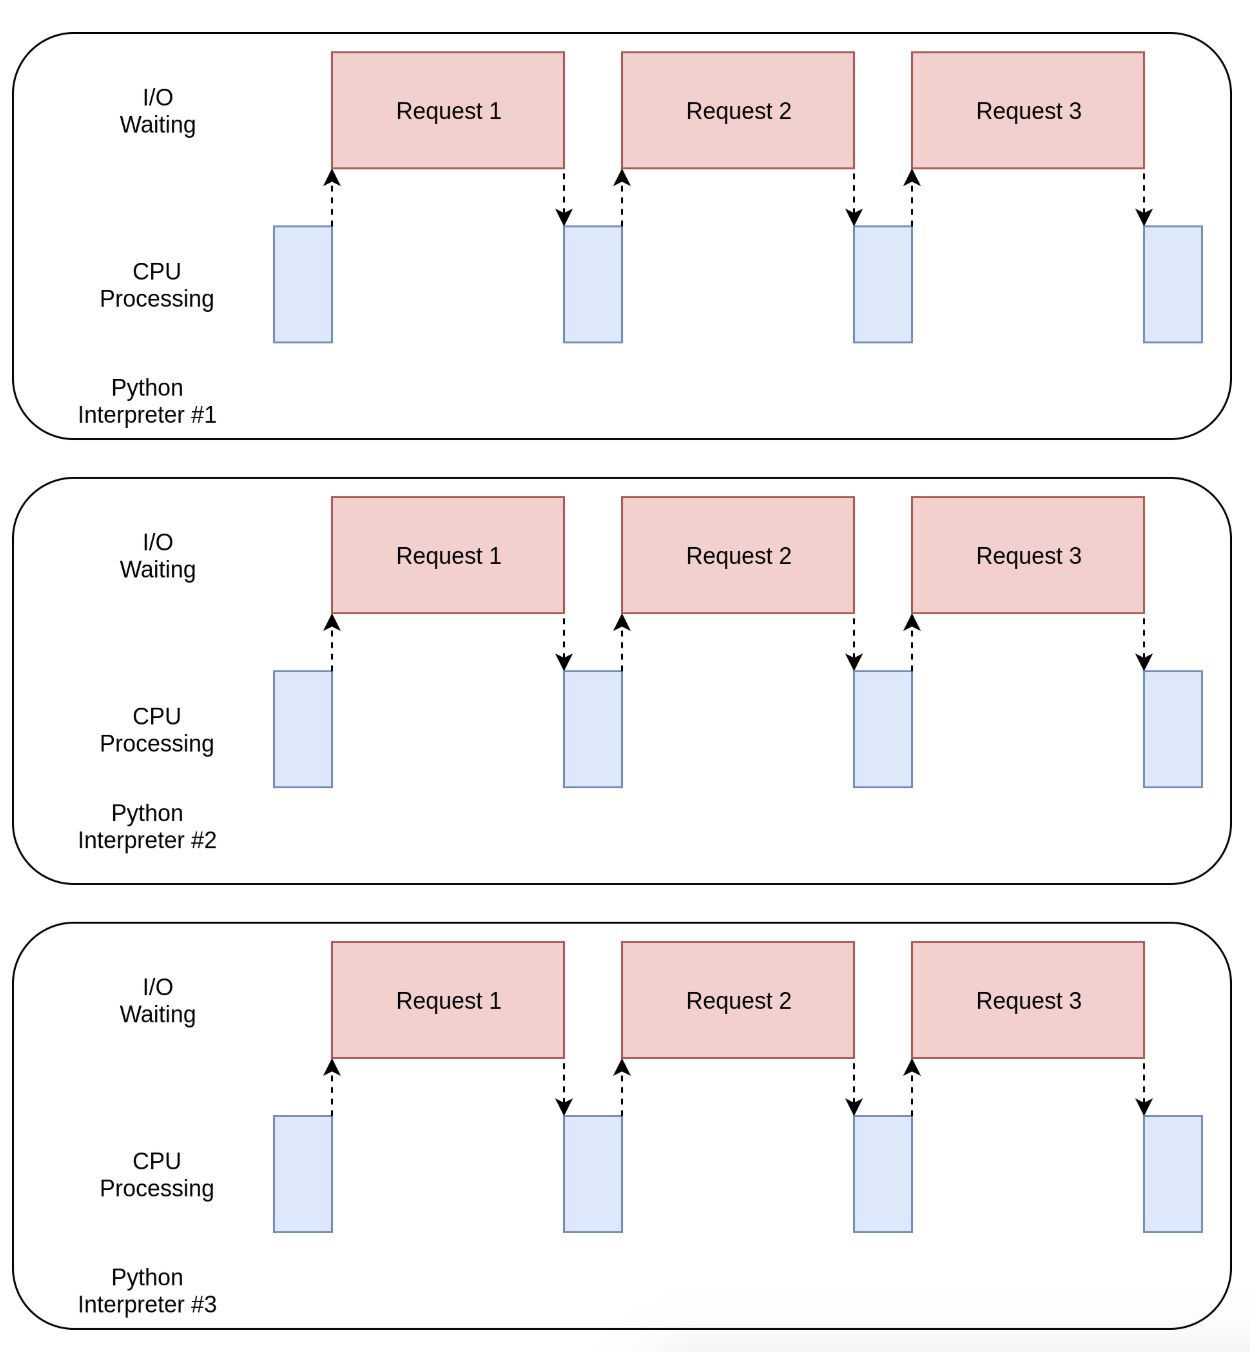

In [34]:
Image("/Users/shisi/Desktop/multiprocessing.png", height=100, width=600)

In [33]:
import multiprocessing

In [37]:
session = None
def set_global_session():
    """ initialize a global session variable to hold the single session for each process. 
    Because each process has its own memory space, the global for each one will be different.
    """
    global session
    if not session:
        session = requests.Session()

def download_site(url):
    with session.get(url) as response:
        name = multiprocessing.current_process().name
        print(f"{name}:Read {len(response.content)} from {url}")

def download_all_sites(sites):
    with multiprocessing.Pool(initializer=set_global_session) as pool:
        pool.map(download_site, sites)


In [39]:
start_time = time.time()
download_all_sites(sites)
duration = time.time() - start_time
print(f"Downloaded {len(sites)} in {duration} seconds with multiprocessing.")

ForkPoolWorker-5:Read 10287 from https://www.jython.org
ForkPoolWorker-7:Read 10287 from https://www.jython.org
ForkPoolWorker-3:Read 10287 from https://www.jython.org
ForkPoolWorker-1:Read 10287 from https://www.jython.org
ForkPoolWorker-6:Read 274 from http://olympus.realpython.org/dice
ForkPoolWorker-8:Read 274 from http://olympus.realpython.org/dice
ForkPoolWorker-4:Read 274 from http://olympus.realpython.org/dice
ForkPoolWorker-2:Read 274 from http://olympus.realpython.org/dice
ForkPoolWorker-5:Read 274 from http://olympus.realpython.org/dice
ForkPoolWorker-3:Read 274 from http://olympus.realpython.org/dice
ForkPoolWorker-7:Read 274 from http://olympus.realpython.org/dice
ForkPoolWorker-1:Read 274 from http://olympus.realpython.org/dice
ForkPoolWorker-5:Read 10287 from https://www.jython.org
ForkPoolWorker-3:Read 10287 from https://www.jython.org
ForkPoolWorker-7:Read 10287 from https://www.jython.org
ForkPoolWorker-1:Read 10287 from https://www.jython.org
ForkPoolWorker-8:Read 10

ForkPoolWorker-8:Read 274 from http://olympus.realpython.org/dice
ForkPoolWorker-7:Read 10287 from https://www.jython.org
ForkPoolWorker-5:Read 274 from http://olympus.realpython.org/dice
ForkPoolWorker-2:Read 274 from http://olympus.realpython.org/dice
ForkPoolWorker-8:Read 10287 from https://www.jython.org
ForkPoolWorker-6:Read 274 from http://olympus.realpython.org/dice
ForkPoolWorker-1:Read 274 from http://olympus.realpython.org/dice
ForkPoolWorker-4:Read 274 from http://olympus.realpython.org/dice
ForkPoolWorker-2:Read 10287 from https://www.jython.org
ForkPoolWorker-5:Read 10287 from https://www.jython.org
ForkPoolWorker-7:Read 274 from http://olympus.realpython.org/dice
ForkPoolWorker-1:Read 10287 from https://www.jython.org
ForkPoolWorker-6:Read 10287 from https://www.jython.org
ForkPoolWorker-4:Read 10287 from https://www.jython.org
ForkPoolWorker-8:Read 274 from http://olympus.realpython.org/dice
ForkPoolWorker-7:Read 10287 from https://www.jython.org
ForkPoolWorker-8:Read 10

##### CPU-Bound multiprocessing

In [43]:
def cpu_bound(number):
    return sum(i * i for i in range(number))

numbers = [5_000_000 + x for x in range(20)] #make up large numbers

In [47]:
### regular looping
def find_sums(numbers):
    for number in numbers:
        cpu_bound(number)

start_time = time.time()
find_sums(numbers)
duration = time.time() - start_time
print(f"Duration {duration} seconds with looping")

Duration 9.189363956451416 seconds with looping


In [46]:
def find_sums(numbers):
    with multiprocessing.Pool() as pool:
        pool.map(cpu_bound, numbers)
        
start_time = time.time()
find_sums(numbers)
duration = time.time() - start_time
print(f"Duration {duration} seconds with multiprocessing")

Duration 2.9117989540100098 seconds with multiprocessing
